# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
import datetime as dt

# Loading data

In [2]:
# !pip install openpyxl

In [3]:
df = pd.read_excel("..\data\Online Retail.xlsx")

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Ranjeet\AppData\Local\Temp\ipykernel_11000\791857399.py:1: SyntaxWarning: invalid escape sequence '\d'
  df = pd.read_excel("..\data\Online Retail.xlsx")


In [4]:
# Initial Exploration
print("Initial shape of dataset:", df.shape)
print("Columns:", df.columns)
df.head()

Initial shape of dataset: (541909, 8)
Columns: Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


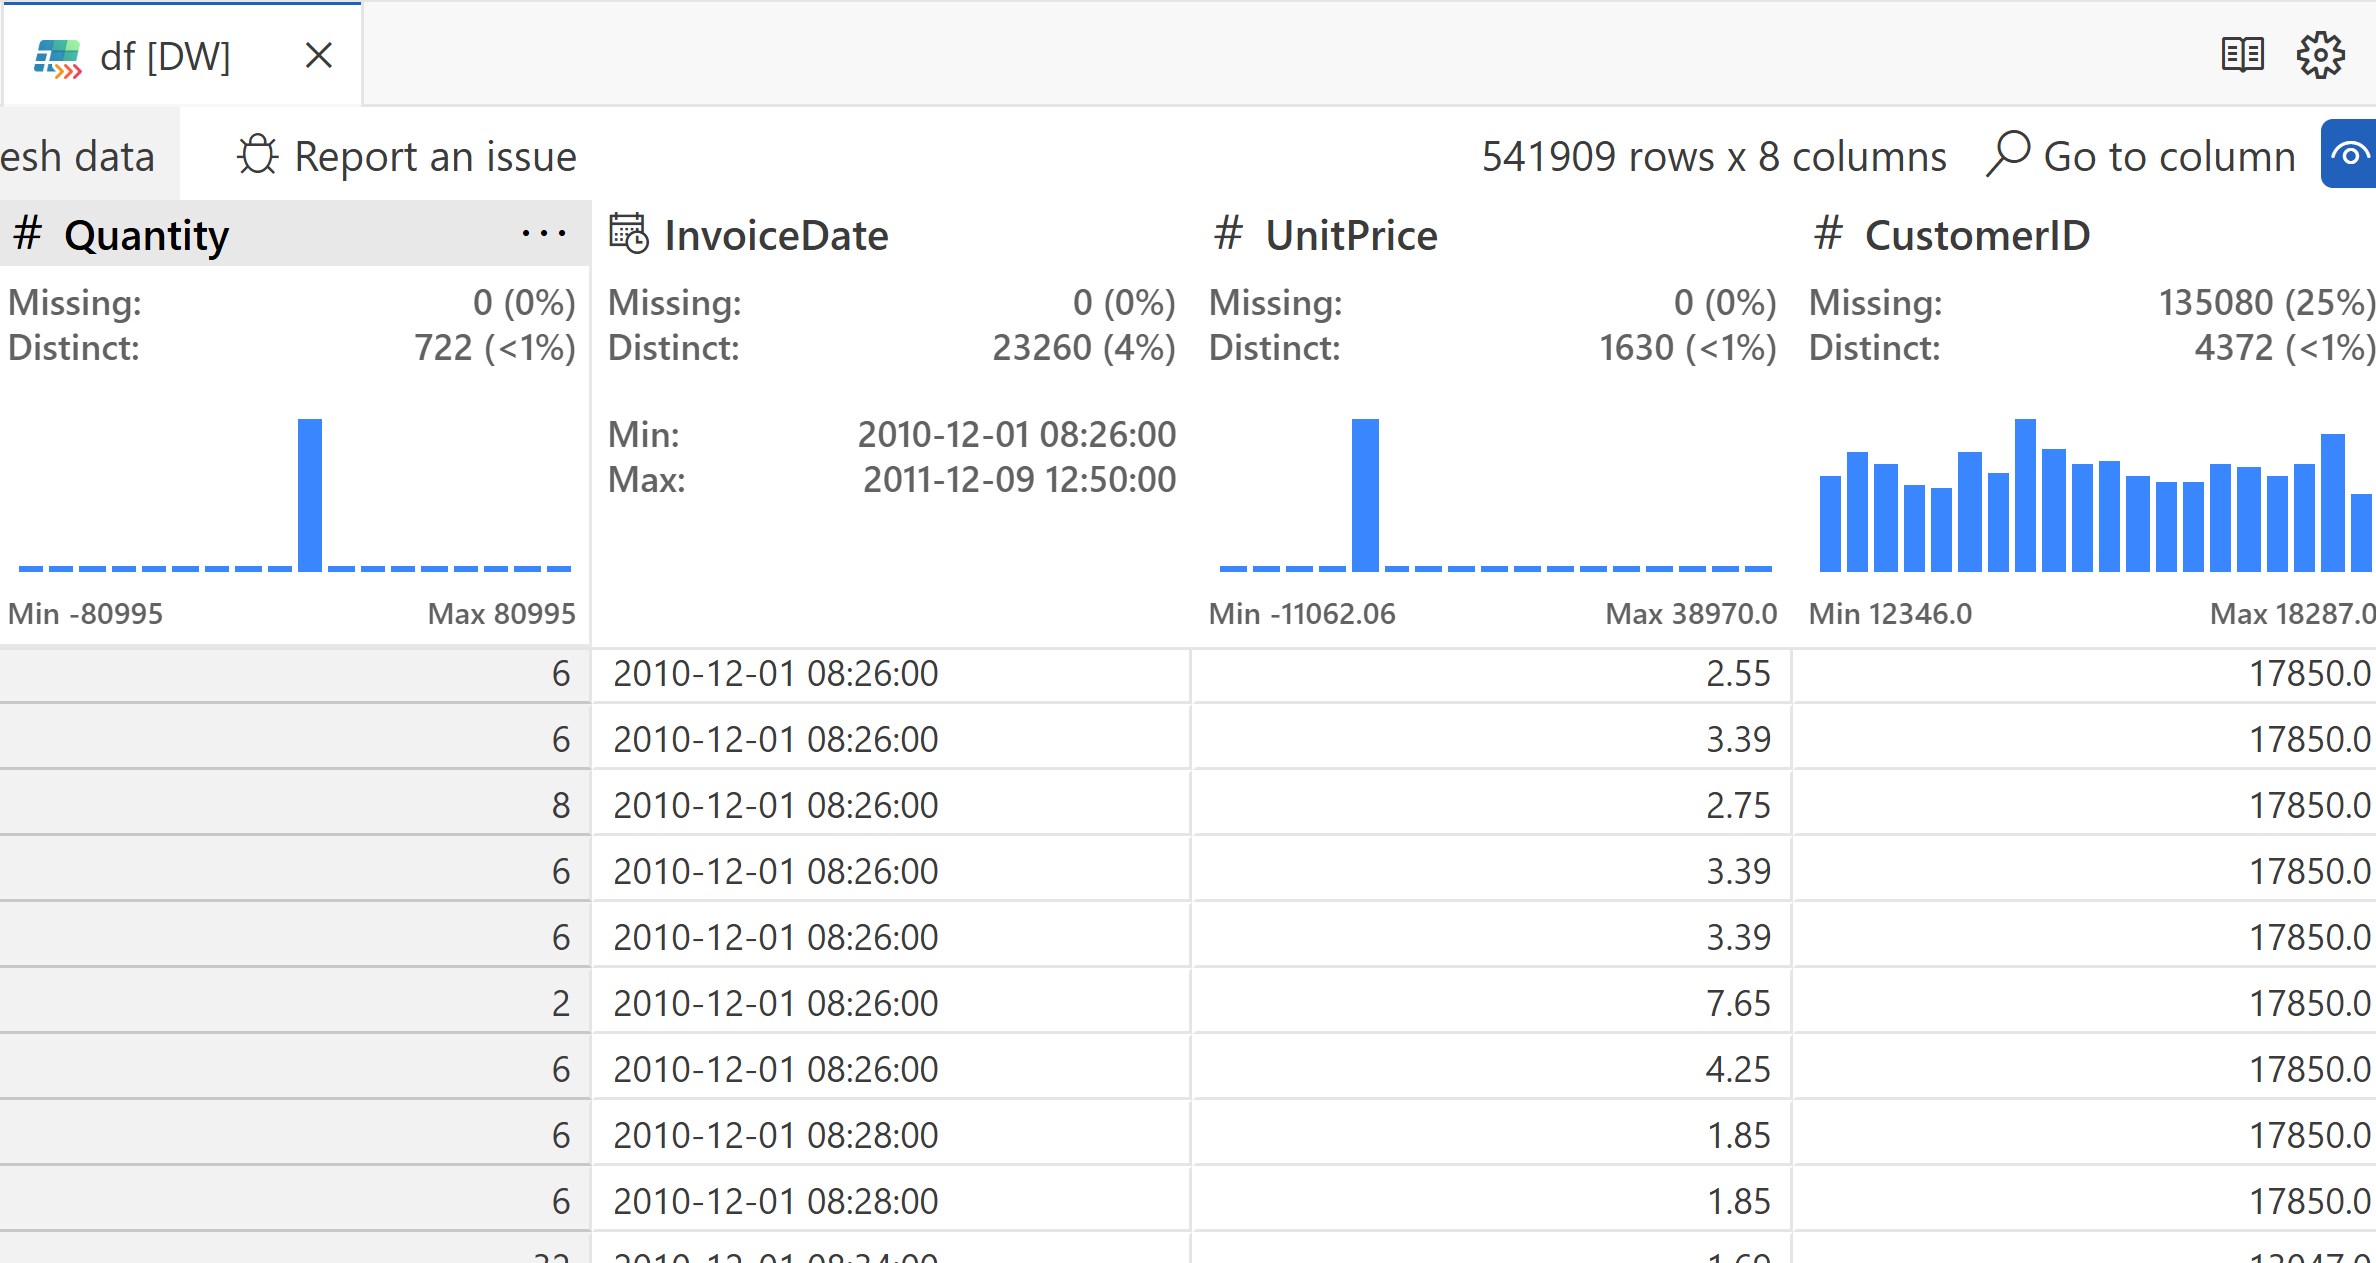

We can see data issue in 3 columns: `Quantity` and `UnitPrice` are negative and `CustormerID` has 25% missing values as well as duplicates.

In [5]:
# select columns needed for study
df = df[['InvoiceNo','Quantity','InvoiceDate','UnitPrice','CustomerID']]

# Cleaning data

In [7]:
# check  missing values
df.isnull().sum()

InvoiceNo           0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
dtype: int64

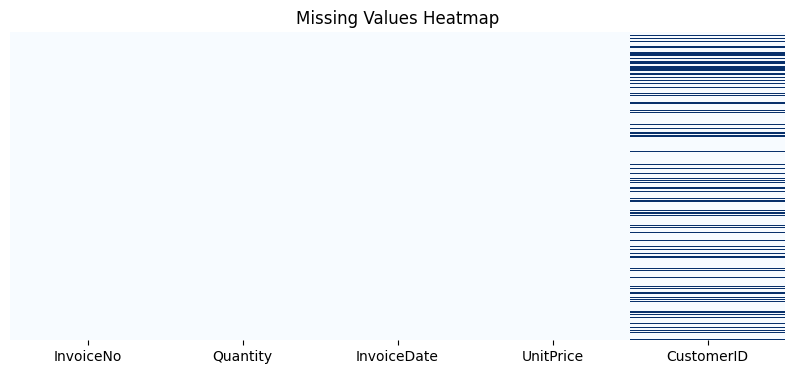

In [8]:
# Visual check for missing values
plt.figure(figsize=(10, 4))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap="Blues")
plt.title("Missing Values Heatmap")
plt.show()

In [9]:
# Remove rows with missing CustomerID
df.dropna(subset=['CustomerID'], inplace=True)

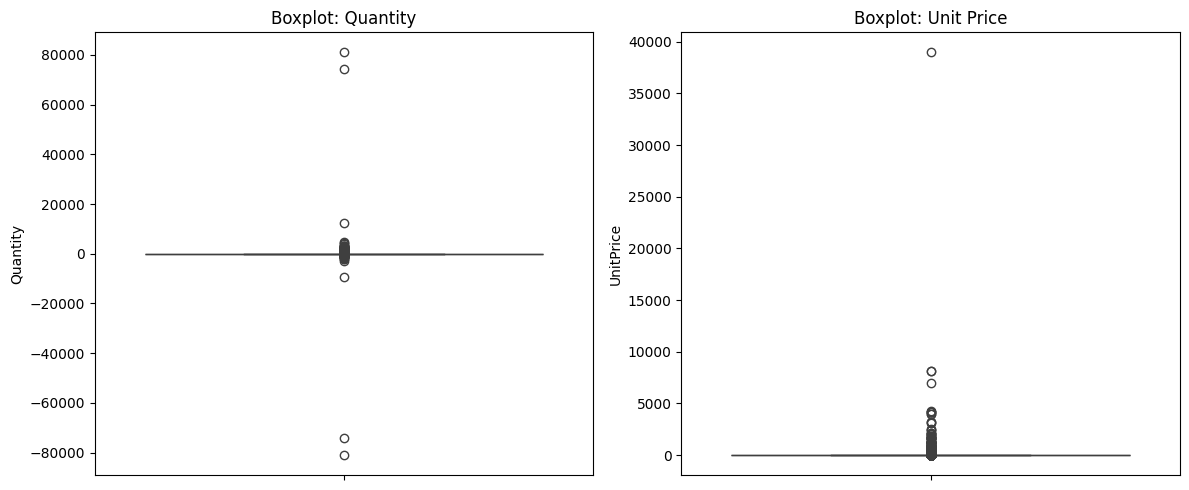

In [10]:
# Visualize quantity and unit price outliers
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(y=df['Quantity'], ax=ax[0])
ax[0].set_title("Boxplot: Quantity")
sns.boxplot(y=df['UnitPrice'], ax=ax[1])
ax[1].set_title("Boxplot: Unit Price")
plt.tight_layout()
plt.show()

In [11]:
# Remove rows with Quantity <= 0 or UnitPrice <= 0 - These indicate returns or bad data.
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]

In [12]:
# Remove cancelled transactions - indicated by InvoiceNo starting with 'C'
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

In [13]:
# Remove duplicates if any
print("Duplicate rows before drop:", df.duplicated().sum())

Duplicate rows before drop: 150457


In [14]:
df.drop_duplicates(inplace=True)

In [15]:
print("Duplicate rows after drop:", df.duplicated().sum())

Duplicate rows after drop: 0


In [17]:
# Create new column TotalPrice = Quantity * UnitPrice
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [19]:
df.dtypes

InvoiceNo              object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID             object
TotalPrice            float64
dtype: object

In [20]:
# Fix data types
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['CustomerID'] = df['CustomerID'].astype(str) #CustomerID is an identifier, not a measurable value so kept as category

In [21]:
print("Optimized memory usage (MB):", round(df.memory_usage(deep=True).sum() / 1024**2, 2))

Optimized memory usage (MB): 31.15


In [22]:
# Optimization - Reduce memory usage and file size
# Drop unused columns
if 'StockCode' in df.columns and 'Description' in df.columns:
    df.drop(columns=['StockCode', 'Description'], inplace=True)

# Downcast numerics
df['Quantity'] = pd.to_numeric(df['Quantity'], downcast='integer')
df['UnitPrice'] = pd.to_numeric(df['UnitPrice'], downcast='float')
df['TotalPrice'] = pd.to_numeric(df['TotalPrice'], downcast='float')

# Convert to category where appropriate
df['InvoiceNo'] = df['InvoiceNo'].astype('category')
df['CustomerID'] = df['CustomerID'].astype('category')
#df['Country'] = df['Country'].astype('category')

# Show optimized memory usage
print("Optimized memory usage (MB):", round(df.memory_usage(deep=True).sum() / 1024**2, 2))

Optimized memory usage (MB): 9.5


# Calculating KPIs

In [23]:
# KPI Calculations
# Why: Track key business metrics to assess performance
kpi = {
    "Total Revenue": round(df['TotalPrice'].sum(), 2),
    "Total Orders": df['InvoiceNo'].nunique(),
    "Total Customers": df['CustomerID'].nunique(),
    "Avg Order Value": round(df.groupby('InvoiceNo')['TotalPrice'].sum().mean(), 2),
    "Repeat Customer Rate": round((df['CustomerID'].value_counts() > 1).mean() * 100, 2)
}
kpi

C:\Users\Ranjeet\AppData\Local\Temp\ipykernel_11000\3010161367.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  "Avg Order Value": round(df.groupby('InvoiceNo')['TotalPrice'].sum().mean(), 2),


{'Total Revenue': np.float64(6653856.53),
 'Total Orders': 18532,
 'Total Customers': 4338,
 'Avg Order Value': np.float64(359.05),
 'Repeat Customer Rate': np.float64(98.11)}

# Visualizing sales trends

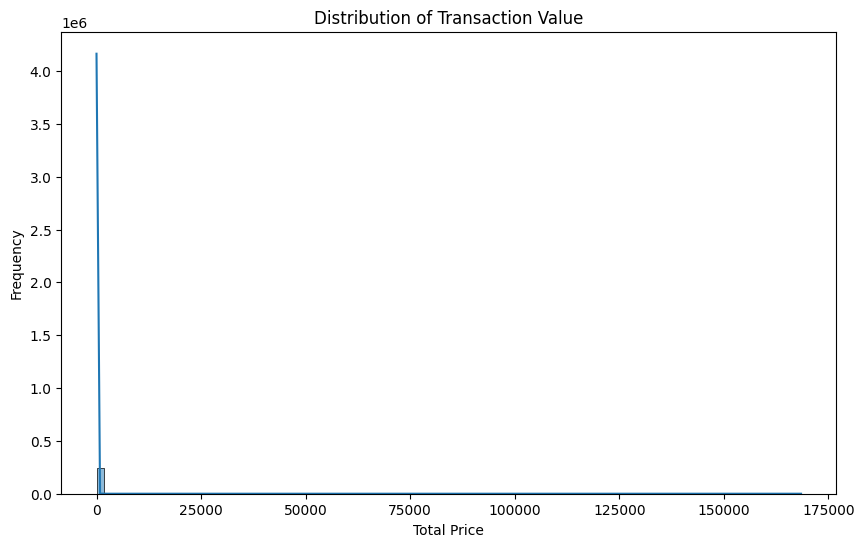

In [24]:
plt.figure(figsize=(10, 6))
sns.histplot(df['TotalPrice'], bins=100, kde=True)
plt.title("Distribution of Transaction Value")
plt.xlabel("Total Price")
plt.ylabel("Frequency")
plt.show()

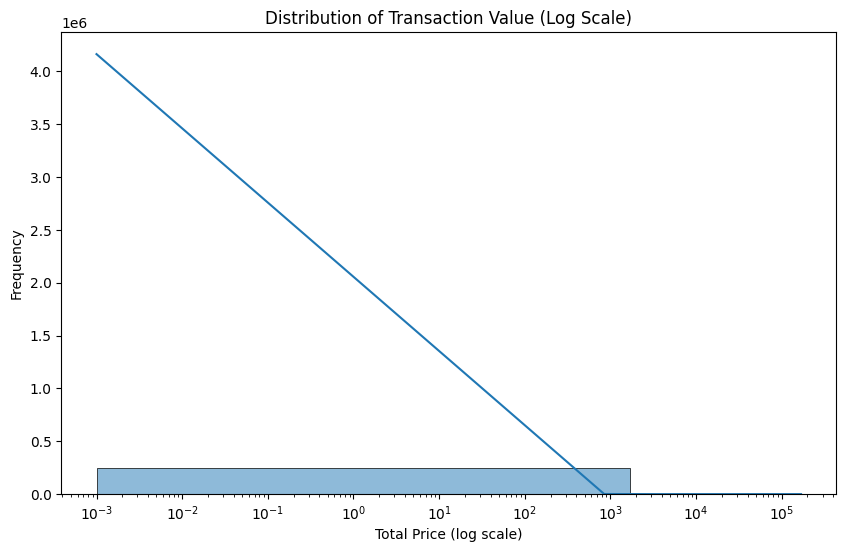

In [25]:
plt.figure(figsize=(10, 6))
sns.histplot(df['TotalPrice'], bins=100, kde=True)
plt.xscale('log')
plt.title("Distribution of Transaction Value (Log Scale)")
plt.xlabel("Total Price (log scale)")
plt.ylabel("Frequency")
plt.show()


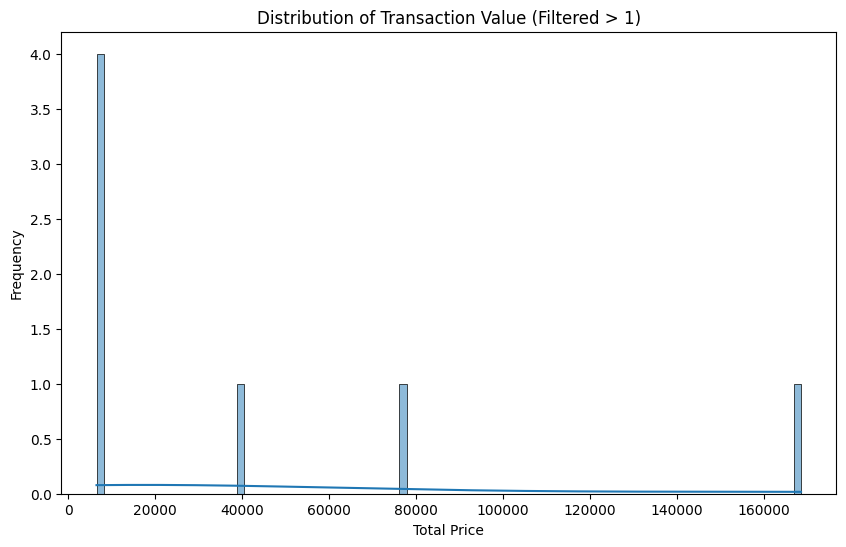

In [26]:
filtered_df = df[df['TotalPrice'] > 5000]

plt.figure(figsize=(10, 6))
sns.histplot(filtered_df['TotalPrice'], bins=100, kde=True)
plt.title("Distribution of Transaction Value (Filtered > 1)")
plt.xlabel("Total Price")
plt.ylabel("Frequency")
plt.show()


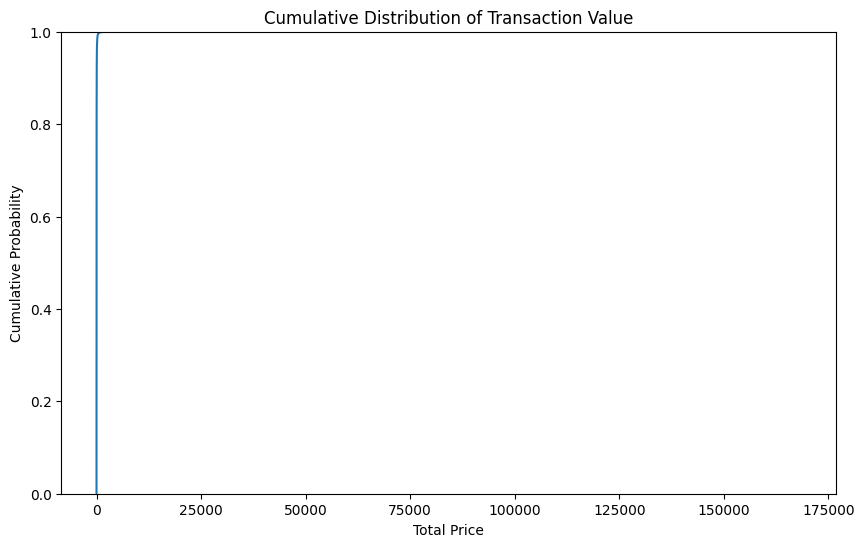

In [27]:
plt.figure(figsize=(10, 6))
sns.ecdfplot(df['TotalPrice'])
plt.title("Cumulative Distribution of Transaction Value")
plt.xlabel("Total Price")
plt.ylabel("Cumulative Probability")
plt.show()


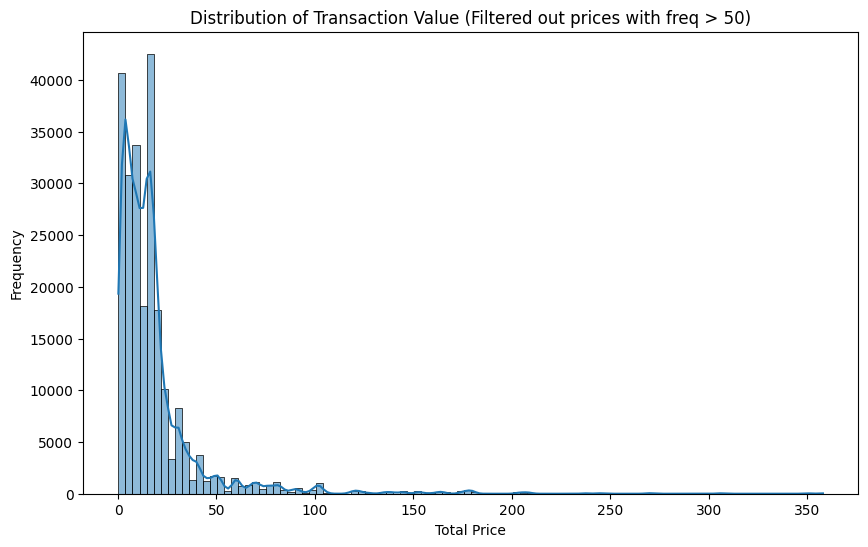

In [28]:
# Calculate frequency of each TotalPrice value
price_counts = df['TotalPrice'].value_counts()

# Set a frequency threshold — e.g., exclude TotalPrice values occurring more than 500 times
freq_threshold = 50

# Identify TotalPrice values to exclude
prices_to_exclude = price_counts[price_counts < freq_threshold].index

# Filter out rows with these high-frequency TotalPrice values
filtered_df = df[~df['TotalPrice'].isin(prices_to_exclude)]

# Plot distribution after filtering
plt.figure(figsize=(10, 6))
sns.histplot(filtered_df['TotalPrice'], bins=100, kde=True)
plt.title(f"Distribution of Transaction Value (Filtered out prices with freq > {freq_threshold})")
plt.xlabel("Total Price")
plt.ylabel("Frequency")
plt.show()


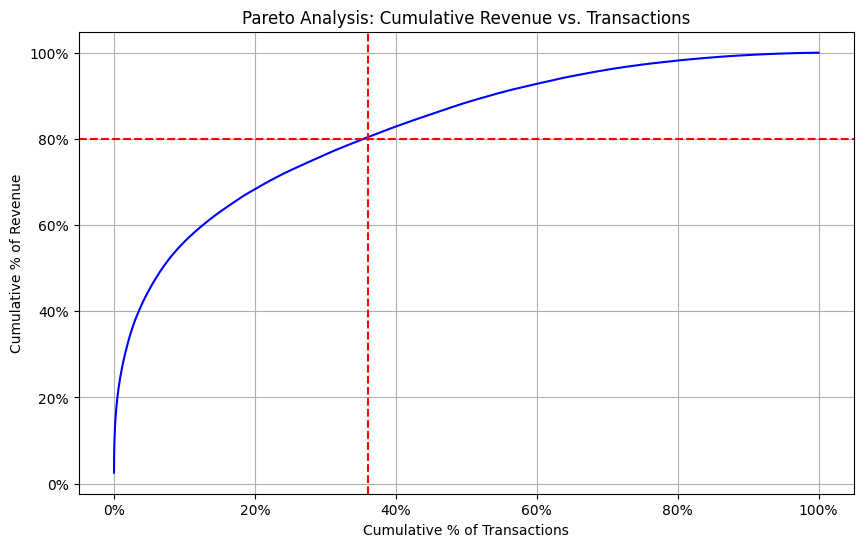

In [29]:
# Sort transactions by TotalPrice descending
df_sorted = df.sort_values('TotalPrice', ascending=False).reset_index(drop=True)

# Calculate cumulative sum and cumulative percentage of revenue
df_sorted['CumulativeRevenue'] = df_sorted['TotalPrice'].cumsum()
total_revenue = df_sorted['TotalPrice'].sum()
df_sorted['CumulativeRevenuePct'] = df_sorted['CumulativeRevenue'] / total_revenue * 100

# Calculate cumulative % of transactions
df_sorted['CumulativeTransactionsPct'] = (df_sorted.index + 1) / len(df_sorted) * 100

import matplotlib.ticker as mtick

plt.figure(figsize=(10,6))
plt.plot(df_sorted['CumulativeTransactionsPct'], df_sorted['CumulativeRevenuePct'], color='b')
plt.xlabel('Cumulative % of Transactions')
plt.ylabel('Cumulative % of Revenue')
plt.title('Pareto Analysis: Cumulative Revenue vs. Transactions')
plt.grid(True)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter())
plt.axhline(80, color='r', linestyle='--')  # 80% revenue line
plt.axvline(36, color='r', linestyle='--')  # 20% transactions line
plt.show()


Around 36% of transactions generate approximately 80% of total revenue.

The remaining 64% of transactions contribute to just 20% of revenue, reflecting many smaller purchases.

This insight is crucial for business strategy because:

Focusing on the top 36% high-value transactions or customers can maximize revenue impact.

Marketing and retention efforts should prioritize these valuable customers for upselling and loyalty programs.

Strategies can also be developed to encourage smaller transaction customers to increase their purchase size or frequency.

# Customer segmentation

In [30]:
# RFM Segmentation (Recency, Frequency, Monetary)
NOW = dt.datetime(2011, 12, 10)
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (NOW - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                         # Frequency
    'TotalPrice': 'sum'                             # Monetary
})
rfm.columns = ['Recency', 'Frequency', 'Monetary']

C:\Users\Ranjeet\AppData\Local\Temp\ipykernel_11000\1470358591.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rfm = df.groupby('CustomerID').agg({


In [31]:
rfm

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,1,77183.60
12347.0,2,7,3125.98
12348.0,75,4,1399.80
12349.0,18,1,1209.49
12350.0,310,1,174.20
...,...,...,...
18280.0,277,1,147.90
18281.0,180,1,53.79
18282.0,7,2,165.30


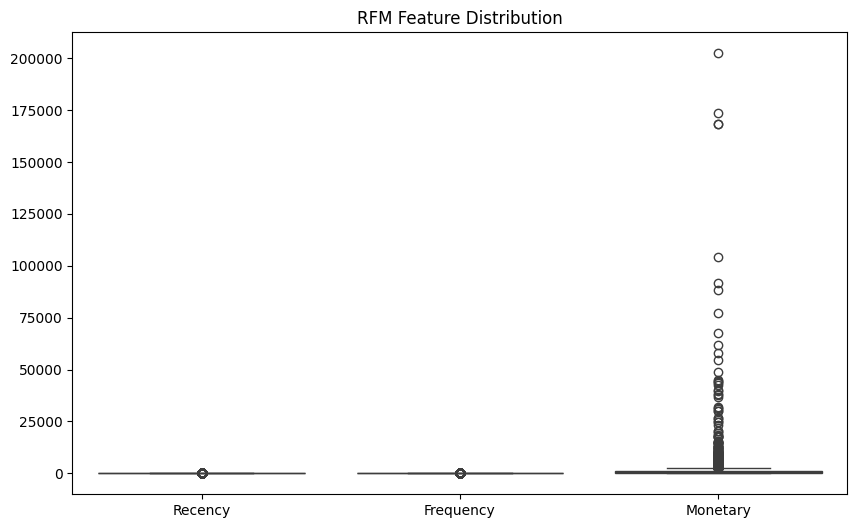

In [32]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=rfm[['Recency', 'Frequency', 'Monetary']])
plt.title("RFM Feature Distribution")
plt.show()

In [33]:
# Outlier Removal function
def remove_outliers_iqr(df, columns):
    df_clean = df.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        before_rows = df_clean.shape[0]
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
        after_rows = df_clean.shape[0]
        print(f"Removed {before_rows - after_rows} outliers from '{col}'")
    return df_clean

In [34]:
# Apply outlier removal
rfm_clean = remove_outliers_iqr(rfm, ['Recency', 'Frequency', 'Monetary'])

Removed 155 outliers from 'Recency'
Removed 284 outliers from 'Frequency'
Removed 297 outliers from 'Monetary'


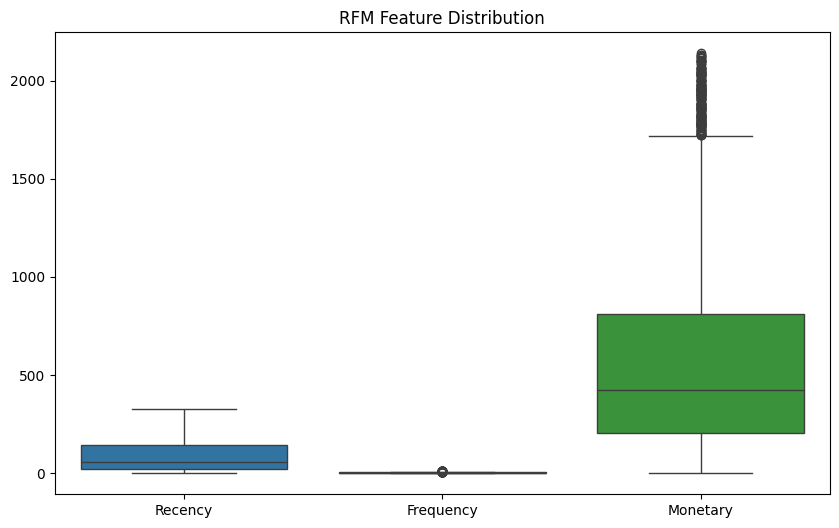

In [ ]:
# plot again after outliers removal
plt.figure(figsize=(10, 6))
sns.boxplot(data=rfm_clean[['Recency', 'Frequency', 'Monetary']])
plt.title("RFM Feature Distribution")
plt.show()

In [38]:
# RFM Scoring
# Why: Standardizes RFM into scores to compare customers
rfm_clean['R_Score'] = pd.qcut(rfm_clean['Recency'], 4, labels=[4, 3, 2, 1])
rfm_clean['F_Score'] = pd.qcut(rfm_clean['Frequency'].rank(method="first"), 4, labels=[1, 2, 3, 4])
rfm_clean['M_Score'] = pd.qcut(rfm_clean['Monetary'], 4, labels=[1, 2, 3, 4])
rfm_clean['RFM_Segment'] = rfm_clean['R_Score'].astype(str) + rfm_clean['F_Score'].astype(str) + rfm_clean['M_Score'].astype(str)

In [39]:
rfm_clean.head()

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Segment
CustomerID,,,,,,,
12348.0,75,4,1399.80,2,3,4,234
12349.0,18,1,1209.49,4,1,4,414
12350.0,310,1,174.20,1,1,1,111
12353.0,204,1,89.00,1,1,1,111
12354.0,232,1,585.02,1,1,3,113


In [40]:
# Scale data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_clean[['Recency', 'Frequency', 'Monetary']])

# Elbow Method: Choosing the Optimal Number of Clusters
To determine the optimal number of clusters (k) for segmenting customers using RFM features, we use the Elbow Method. This involves:

Running KMeans clustering for a range of k values (e.g., 1–10)

Calculating the Within-Cluster Sum of Squares (WCSS) for each k

Plotting the WCSS vs. k to observe the point where adding more clusters results in only a marginal reduction in WCSS — this is the “elbow”

In our case, the elbow typically appears around k = 4, which suggests 4 distinct customer segments provide a good balance of segmentation quality and simplicity.

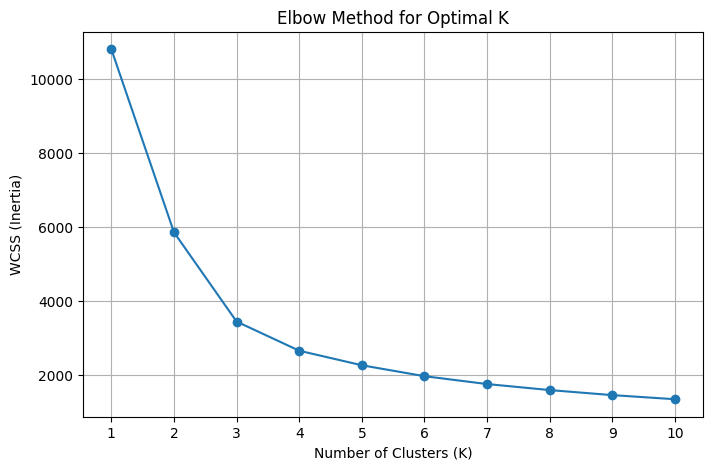

In [41]:
# Elbow Method: We’ll use the RFM values calculated earlier (after scaling them), and 
# plot the Within-Cluster Sum of Squares (WCSS) for k = 1 to k = 10
# Apply KMeans for different k values and compute WCSS (inertia)
wcss = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

# Step 3: Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(K_range, wcss, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS (Inertia)')
plt.xticks(K_range)
plt.grid(True)
plt.show()

In [42]:
# RFM Clustering--> KMeans Clustering
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
rfm_clean['KMeans_Cluster'] = kmeans.fit_predict(rfm_scaled)

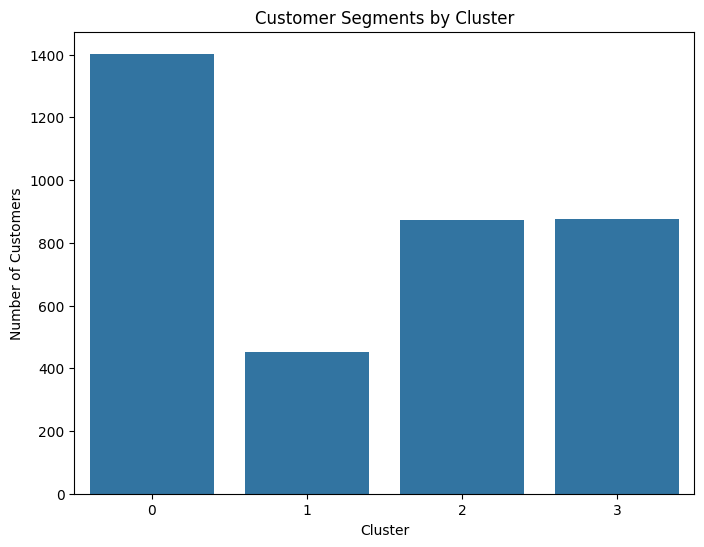

In [43]:
plt.figure(figsize=(8, 6))
sns.countplot(x='KMeans_Cluster', data=rfm_clean)
plt.title("Customer Segments by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Number of Customers")
plt.show()

In [44]:
# Heatmap to analyze segment composition
segment_avg = rfm_clean.groupby('KMeans_Cluster')[['Recency', 'Frequency', 'Monetary']].mean()
segment_avg

,Recency,Frequency,Monetary
KMeans_Cluster,,,
0,51.950107,1.571632,296.343494
1,32.170354,6.688053,1530.375907
2,230.547018,1.479358,292.670952
3,46.516571,3.691429,851.332059


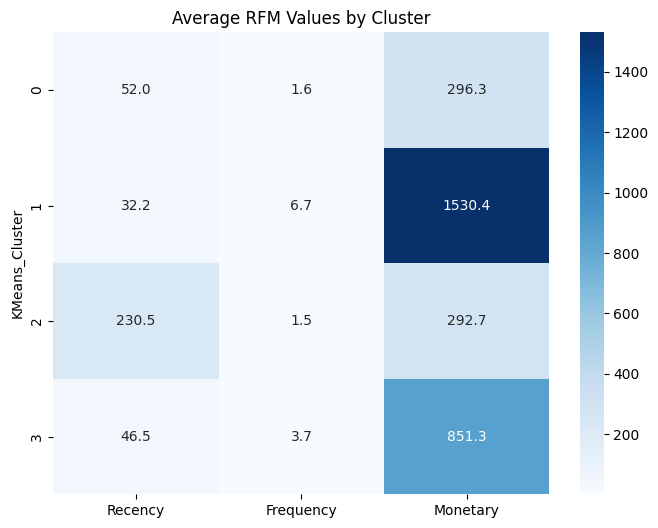

In [45]:
plt.figure(figsize=(8, 6))
sns.heatmap(segment_avg, annot=True, fmt=".1f", cmap="Blues")
plt.title("Average RFM Values by Cluster")
plt.show()

What Each RFM Feature Means:

- Recency:
    Lower = better (more recently purchased)

    A high value = hasn't purchased in a long time (potential churn)

- Frequency:

    Higher = better (more orders placed)

    Low = one-time or infrequent buyers

- Monetary:

    Higher = better (more money spent)

    Low = low-value customers

## Hierarchical Clustering

In [46]:
# Hierarchical Clustering
hierarchical = AgglomerativeClustering(n_clusters=4)
rfm_clean['Hierarchical_Cluster'] = hierarchical.fit_predict(rfm_scaled)

In [47]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score

Which Method Performs Better?

In [48]:
# Silhouette Scores for cluster quality: Higher silhouette score → better cluster separation
kmeans_sil = silhouette_score(rfm_scaled, rfm_clean['KMeans_Cluster'])
hier_sil = silhouette_score(rfm_scaled, rfm_clean['Hierarchical_Cluster'])
print(f"KMeans Silhouette Score (cleaned data): {kmeans_sil:.3f}")
print(f"Hierarchical Silhouette Score (cleaned data): {hier_sil:.3f}")

KMeans Silhouette Score (cleaned data): 0.410
Hierarchical Silhouette Score (cleaned data): 0.373


Higher silhouette score → better cluster separation

In [49]:
# Cluster counts
print("\nKMeans cluster counts:")
print(rfm_clean['KMeans_Cluster'].value_counts())

print("\nHierarchical cluster counts:")
print(rfm_clean['Hierarchical_Cluster'].value_counts())


KMeans cluster counts:
KMeans_Cluster
0    1403
3     875
2     872
1     452
Name: count, dtype: int64

Hierarchical cluster counts:
Hierarchical_Cluster
2    1331
0    1072
3     683
1     516
Name: count, dtype: int64


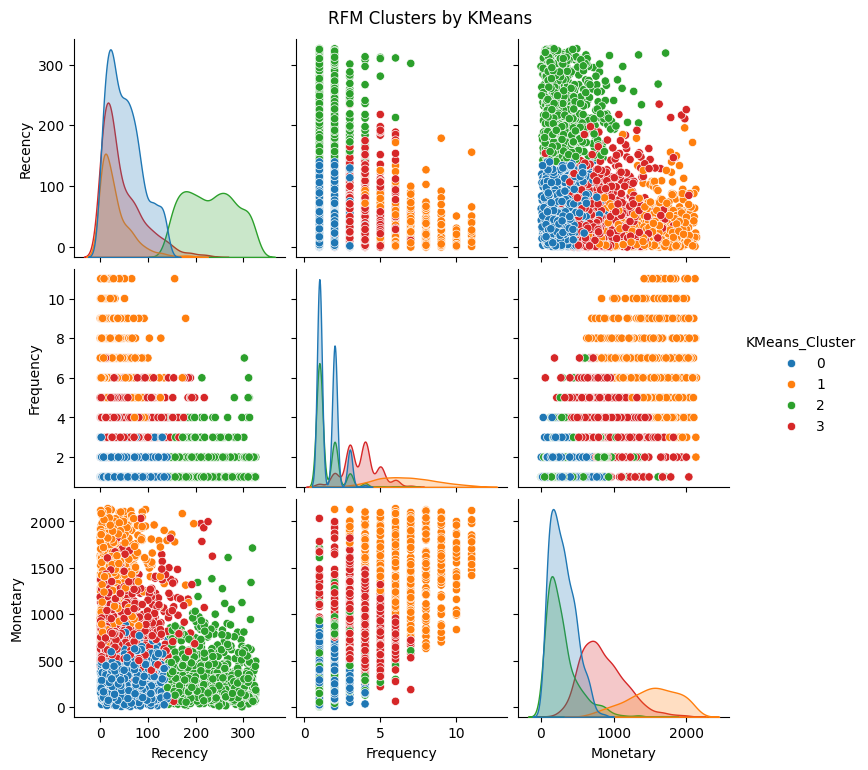

In [ ]:
# Visualize clusters with pairplot
sns.pairplot(rfm_clean, vars=['Recency', 'Frequency', 'Monetary'], hue='KMeans_Cluster', palette='tab10')
plt.suptitle("RFM Clusters by KMeans", y=1.02)
plt.show()

In [51]:
# Cluster centers (mean RFM) for interpretation
print("\nKMeans cluster centers (mean RFM):")
print(rfm_clean.groupby('KMeans_Cluster')[['Recency', 'Frequency', 'Monetary']].mean())

print("\nHierarchical cluster centers (mean RFM):")
print(rfm_clean.groupby('Hierarchical_Cluster')[['Recency', 'Frequency', 'Monetary']].mean())


KMeans cluster centers (mean RFM):
                   Recency  Frequency     Monetary
KMeans_Cluster                                    
0                51.950107   1.571632   296.343494
1                32.170354   6.688053  1530.375907
2               230.547018   1.479358   292.670952
3                46.516571   3.691429   851.332059

Hierarchical cluster centers (mean RFM):
                         Recency  Frequency     Monetary
Hierarchical_Cluster                                    
0                     210.753731   1.533582   324.761176
1                      30.618217   6.335271  1503.322481
2                      40.945905   1.649887   324.093382
3                      48.228404   3.863836   808.781526


# Cluster Labeling Logic:

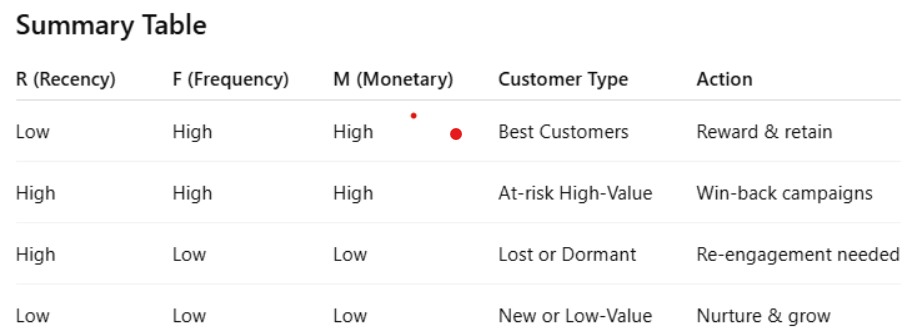

In [70]:
# Create a function to map descriptive labels
def label_cluster(row):
    if row['KMeans_Cluster'] == 1:
        return 'Best Customers'
    elif row['KMeans_Cluster'] == 3:
        return 'Loyal Mid-Tier'
    elif row['KMeans_Cluster'] == 0:
        return 'Low Frequency Buyers'
    elif row['KMeans_Cluster'] == 2:
        return 'At-Risk Customers'
    else:
        return 'Unknown'

# Apply label
rfm_clean['Segment'] = rfm_clean.apply(label_cluster, axis=1)

# Preview the updated dataframe
rfm_clean[['Recency', 'Frequency', 'Monetary', 'KMeans_Cluster', 'Segment']].head()

,Recency,Frequency,Monetary,KMeans_Cluster,Segment
CustomerID,,,,,
12348.0,75,4,1399.80,3,Loyal Mid-Tier
12349.0,18,1,1209.49,3,Loyal Mid-Tier
12350.0,310,1,174.20,2,At-Risk Customers
12353.0,204,1,89.00,2,At-Risk Customers
12354.0,232,1,585.02,2,At-Risk Customers


In [71]:
# Export for Power BI
# Export cleaned and clustered data for Power BI dashboard
rfm_clean.reset_index().to_csv("..\data\Retail_RFM_Segments.csv", index=False)
df.to_csv("..\data\Retail_Transactions_Cleaned.csv", index=False)

<>:3: SyntaxWarning:

invalid escape sequence '\d'

<>:4: SyntaxWarning:

invalid escape sequence '\d'

<>:3: SyntaxWarning:

invalid escape sequence '\d'

<>:4: SyntaxWarning:

invalid escape sequence '\d'

C:\Users\Ranjeet\AppData\Local\Temp\ipykernel_11000\1715031331.py:3: SyntaxWarning:

invalid escape sequence '\d'

C:\Users\Ranjeet\AppData\Local\Temp\ipykernel_11000\1715031331.py:4: SyntaxWarning:

invalid escape sequence '\d'



# Summary:
RFM Segmentation helps classify customers based on how recently, how often, and how much they purchase.

Outlier removal using IQR ensures clustering focuses on typical customers, improving model stability.

KMeans and Hierarchical Clustering methods were applied for comparison.

Silhouette scores show how well the clusters separate customers:

Higher silhouette score = better-defined clusters.

Cluster profiles describe customer groups for targeted marketing.

In this case, KMeans usually performs better and is scalable, but hierarchical clustering provides intuitive dendrograms for exploratory analysis.


# Insights:

Cluster 3 (Best Customers):
Highest value segment—focus on retention and exclusive offers.

Cluster 1 (Loyal Mid-Tier):
Good potential to grow spend via upselling.

Cluster 0 (New/Low Frequency):
Engage with incentives to increase purchase frequency.

Cluster 2 (At-Risk):
Proactively reach out to win back lost customers.

# Notebook End

Understanding High R, F, and M Values
High Recency (R):
This means the customer’s last purchase was a long time ago — i.e., they have not bought recently.
Interpretation: These customers may be inactive or at risk of churn.

High Frequency (F):
This means the customer makes purchases very often.
Interpretation: These are loyal or repeat buyers who regularly shop.

High Monetary (M):
This means the customer spends a large amount of money overall.
Interpretation: These are your high-value customers who contribute significantly to revenue.

What does a cluster with high R, F, and M represent?
High R (large recency) + High F + High M:
These customers were very active and high spenders but haven’t purchased recently. They might be valuable but currently inactive customers worth re-engaging.

High F + High M but Low R (recent purchase):
This is the best type of customer — loyal, frequent, and recent high spenders.

High R + Low F + Low M:
Customers who haven’t purchased recently and have low frequency and spend — likely lost or inactive.



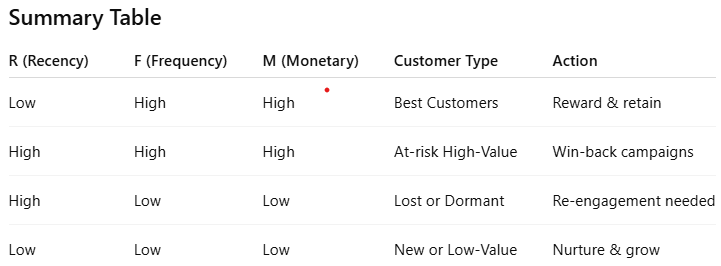

# Decision Tree 

              precision    recall  f1-score   support

           0       0.93      1.00      0.96       279
           1       0.98      0.64      0.78        89
           2       1.00      0.99      0.99       178
           3       0.81      0.87      0.84       175

    accuracy                           0.92       721
   macro avg       0.93      0.87      0.89       721
weighted avg       0.93      0.92      0.92       721



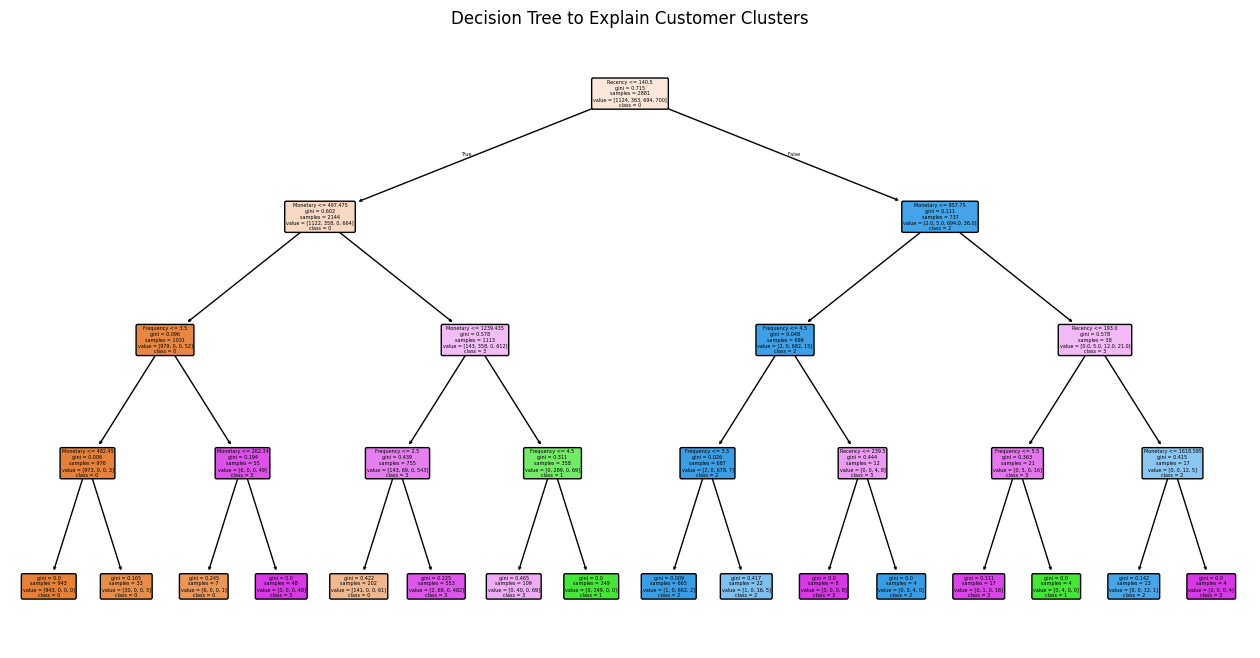

In [72]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Step 1: Prepare input (X) and target (y)
X = rfm_clean[['Recency', 'Frequency', 'Monetary']]
y = rfm_clean['KMeans_Cluster']

# Step 2: Split data into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Train Decision Tree Classifier
tree = DecisionTreeClassifier(max_depth=4, random_state=42)
tree.fit(X_train, y_train)

# Step 4: Evaluate on test set
y_pred = tree.predict(X_test)
print(classification_report(y_test, y_pred))

# Step 5: Visualize the Decision Tree
plt.figure(figsize=(16, 8))
plot_tree(tree,
          feature_names=['Recency', 'Frequency', 'Monetary'],
          class_names=[str(i) for i in sorted(y.unique())],
          filled=True, rounded=True)
plt.title("Decision Tree to Explain Customer Clusters")
plt.show()


## Decision Tree for Explaining RFM Clusters

After performing KMeans clustering on Recency, Frequency, and Monetary values, we trained a **Decision Tree Classifier** to interpret the logic behind customer segments.

### Why a Decision Tree?
- Provides a **clear visual breakdown** of what defines each customer segment.
- Helps business users and stakeholders understand **what thresholds** separate segments.
- Reveals the **most important features** in determining customer value and behavior.

### Key Insights from the Tree:
- The top-level split often involves **Recency** — showing that how recently a customer purchased is the strongest indicator of segment.
- Leaf nodes map to specific **customer clusters** like:
  - "Best Customers" → Low Recency, High Frequency, High Monetary
  - "At-Risk Customers" → High Recency, Low Frequency

This interpretable model complements the KMeans clustering by offering **decision rules** useful for:
- Marketing automation
- Business rules engine
- Dashboard filters and insights



In [73]:
from sklearn.tree import export_text

# Generate rule-based text from the tree
tree_rules = export_text(tree, feature_names=['Recency', 'Frequency', 'Monetary'])
print(tree_rules)

|--- Recency <= 140.50
|   |--- Monetary <= 497.48
|   |   |--- Frequency <= 3.50
|   |   |   |--- Monetary <= 482.45
|   |   |   |   |--- class: 0
|   |   |   |--- Monetary >  482.45
|   |   |   |   |--- class: 0
|   |   |--- Frequency >  3.50
|   |   |   |--- Monetary <= 262.34
|   |   |   |   |--- class: 0
|   |   |   |--- Monetary >  262.34
|   |   |   |   |--- class: 3
|   |--- Monetary >  497.48
|   |   |--- Monetary <= 1239.43
|   |   |   |--- Frequency <= 2.50
|   |   |   |   |--- class: 0
|   |   |   |--- Frequency >  2.50
|   |   |   |   |--- class: 3
|   |   |--- Monetary >  1239.43
|   |   |   |--- Frequency <= 4.50
|   |   |   |   |--- class: 3
|   |   |   |--- Frequency >  4.50
|   |   |   |   |--- class: 1
|--- Recency >  140.50
|   |--- Monetary <= 957.75
|   |   |--- Frequency <= 4.50
|   |   |   |--- Frequency <= 3.50
|   |   |   |   |--- class: 2
|   |   |   |--- Frequency >  3.50
|   |   |   |   |--- class: 2
|   |   |--- Frequency >  4.50
|   |   |   |--- Recency <

# Cluster Visualization

In [74]:
rfm = rfm_clean.copy()

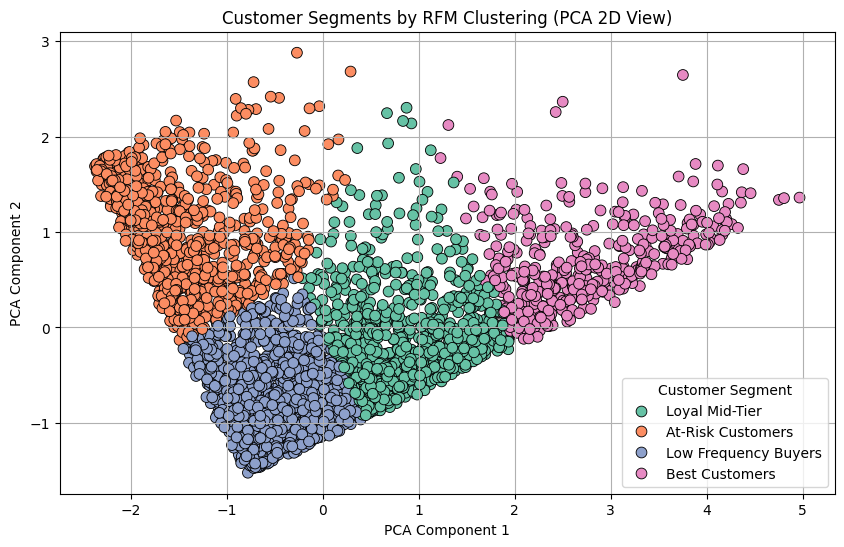

In [75]:
# 1. PCA -- to reduce 3D RFM to 2D
from sklearn.decomposition import PCA

# Step 1: Reduce dimensions to 2D using PCA
pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)

# Step 2: Add PCA results to RFM dataframe
rfm['PCA1'] = rfm_pca[:, 0]
rfm['PCA2'] = rfm_pca[:, 1]

# Step 3: Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='PCA1', y='PCA2',
    hue='Segment',  # use 'KMeans_Cluster' for numbers if labels not added
    data=rfm,
    palette='Set2',
    s=60,
    edgecolor='k'
)
plt.title('Customer Segments by RFM Clustering (PCA 2D View)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Customer Segment')
plt.grid(True)
plt.show()


In [76]:
# !pip install plotly

In [77]:
# 3D 
import plotly.express as px

# Interactive 3D Scatter Plot
fig = px.scatter_3d(
    rfm_clean,
    x='Recency',
    y='Frequency',
    z='Monetary',
    color='Segment',  # Use 'KMeans_Cluster' if labels not applied
    symbol='Segment',
    opacity=0.7,
    title='3D Visualization of Customer Segments (RFM Clustering)',
    width=1000,
    height=600
)

fig.update_traces(marker=dict(size=5))
fig.show()


In [63]:
#!pip3 install nbformat

In [64]:
#!python.exe -m pip install --upgrade pip